# Predicting crowdfunding success of Kickstarter projects

[Kickstarter.com](http://kickstarter.com) provides a crowdsourcing platform for creative projects to be realized. To successfully get enough sponsor from backers, it is crucial to have a good name, blurb and realistic timeline for the crowdsourcing. This project aims at **predicting the success** of projects to have enough money pledged based on these quantities. The ultimate goal is to identify features possessed by successful projects and help future participants better tailor their project presentations.

## Dataset
- The Kickstarter data scraped on on Jan 12, 2018 is retreved from [WebRobot](https://webrobots.io/kickstarter-datasets/) and cleaned with the script *kickstarter-bank.ipynb*. Only projects with known status of success/failure are included. Ongoing projects (minority in the database) are excluded.
- This notebook split the dataset into train (14.6k samples) and test sets (3.6k samples), and feed them into the  predictive models.

## Factors related to success/failure inferred from Exploratory Data Analysis
- There is a separation of the range of goals (USD) among different categories between successful and failed cases. Therefore, the goal and main category together shall be a good predictor of success.

## Predictive Models
Three classifiers are built and combined together by soft-voting (i.e. averaging predicted class probability):
- The **Recurrent Neural Net (RNN)** with LSTM units implements natural language processing on unstructured text data. It makes prediction based on text displayed on Kickstarter page of the project, namely, the name and the blurb of the project. The category and location of the project is also include as part of the text.
- The **RandomForest (RF)** and **Extreme Gradient Boost (XGB)** classifiers are making predictions based on categorical variables such as country and category, and numerical variables such as duration of the campaign and goal of crowdsourcing.


** *Note that the RNN model does not have access the goal of the project, one of the main predictors, at all, but achieves a better prediction (as seen below), indicating that the name and the blurb of the project also provides information about its success.* **


## Model Selection
- Hyperparameters are chosen using grid search/random search based on the mean accuracy and ROC AUC in 5-fold cross-validation (in another set of notebooks). The best set of hyperparameters are used to build models to make predictions on the test set.
- After the three models are tuned, their prediction is combined with soft voting (i.e. averaging their predicted class probability).

## Model Performance
- The accuracy, ROC AUC and F1-score (to address the slight class imbalance) are the main criteria of evaluation of the model.
- The tuned RF (accuracy = 0.774, ROC AUC = 0.863, F1 = 0.808) and XGB model (0.768, 0.862, 0.806) are having similar performance on the test set, while the RNN is performing slightly better (0.782, 0.871, 0.812). The combined model gives the best performance (over all metrics):

|Metric   | Performance |
|---------|-------------|
|Accuracy | 0.8023      |
| ROC AUC | 0.8917      |
| F1      | 0.8307      |

|    | PN    | PP   |
|----|-------|------|
| TN | 11545 | 3208 |
| TP | 3989  | 17654|

##  Thoughts and future work
- The RNN and the two decision tree classifiers are capturing different aspects of the project (goal setting v.s. presentation). Yet, they achieve comparable accuracy, and their combination gives a better predictive model. This indicates that the presentation of the project indeed matters to determining its success.
- Next steps would be to:
    - Extract features in the name/blurb text from RNN/using unsupervised learning and identify features coorrelated to success/failure. 
    - Try using RNN to synthesize text attractive to audience (more like for fun ;) )

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn, seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.optimizers import Adam
from keras.models import Model
from keras import optimizers, layers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
try:
    from keras.layers import Bidirectional, GlobalMaxPooling1D
    from sklearn.model_selection import train_test_split
except:
    from sklearn.cross_validation import train_test_split
    from keras.layers.pooling import MaxPooling1D

# Load my own modules
from diagnostic_plots import diagnostic_print

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Kickstarter_2018-01-12/2018-01-12_all.csv',usecols=range(2,21))

# Specify date format of several columns
df.created_at = pd.to_datetime(df.created_at)
df.launched_at = pd.to_datetime(df.launched_at)
df.deadline = pd.to_datetime(df.deadline)
df.state_changed_at = pd.to_datetime(df.state_changed_at)
df['duration'] = (df['deadline']-df['launched_at']).dt.total_seconds()/24./3600.

# only filter out successful/failed cases
df = df[df['state'].isin(['successful','failed'])]
df['state'] = df['state'].apply(lambda x: 1 if x=='successful' else 0)

# Discard entries with undefined data (non in technology data)
df = df[['main_category','category_name','country','duration','goal','name','blurb','state']]
df.dropna(axis=0, how='any', inplace=True)


# Exploratory data analysis

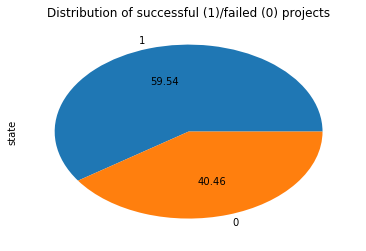

In [26]:
df['state'].value_counts().plot.pie(autopct='%.2f')
plt.title('Distribution of successful (1)/failed (0) projects')

More successful projects are displayed/available on the kickstarter webpage.

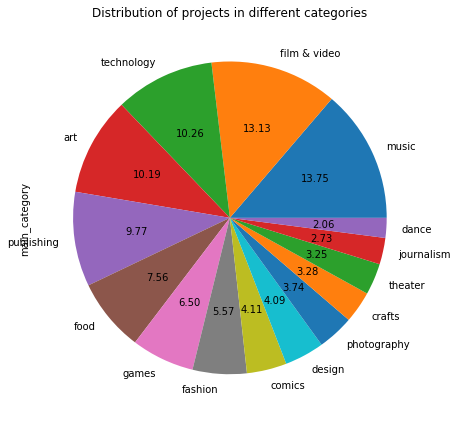

In [37]:
df['main_category'].value_counts().plot.pie(autopct='%.2f',figsize=(6,6))
plt.title('Distribution of projects in different categories')
plt.tight_layout()

The dominating categories arer music, film and video, technology and art.

/Users/shaoyinghuang/anaconda/envs/trytensorflow/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


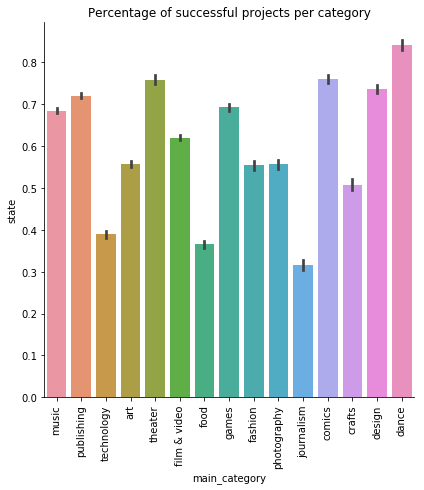

In [40]:
sns.factorplot(x='main_category', y='state', kind='bar', data=df, size=6)
locs, labels = plt.xticks();
plt.title('Percentage of successful projects per category')
plt.setp(labels, rotation=90);

The categories having the smallest proportion of success are journalism, food and technology.

### Are goals set by failed projects unrealistic?

/Users/shaoyinghuang/anaconda/envs/trytensorflow/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


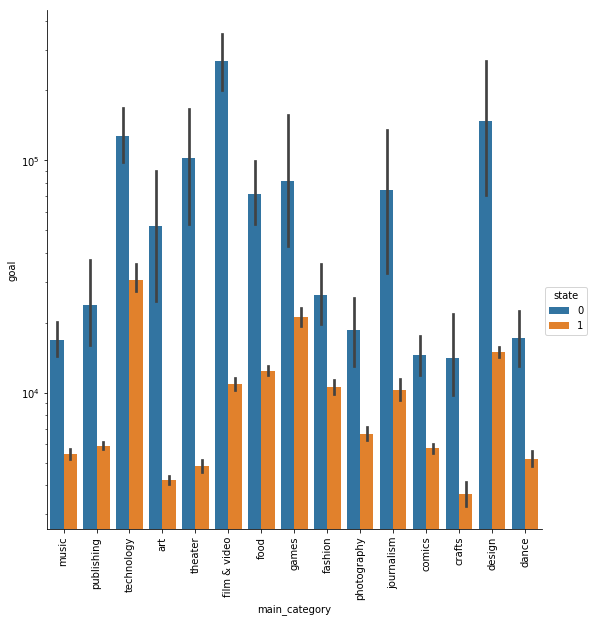

In [3]:
sns.factorplot(x='main_category', y='goal', hue='state', kind='bar', data=df, size=8)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Range of goal ($) among successful and failed projects')
plt.gca().set_yscale("log", nonposy='clip');

From the comparison above, per main category, there is a clear separation of range of goals ($) between successful and failed cases. The successful cases have way lower/achievable goal compared to the failed cases.

/Users/shaoyinghuang/anaconda/envs/trytensorflow/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


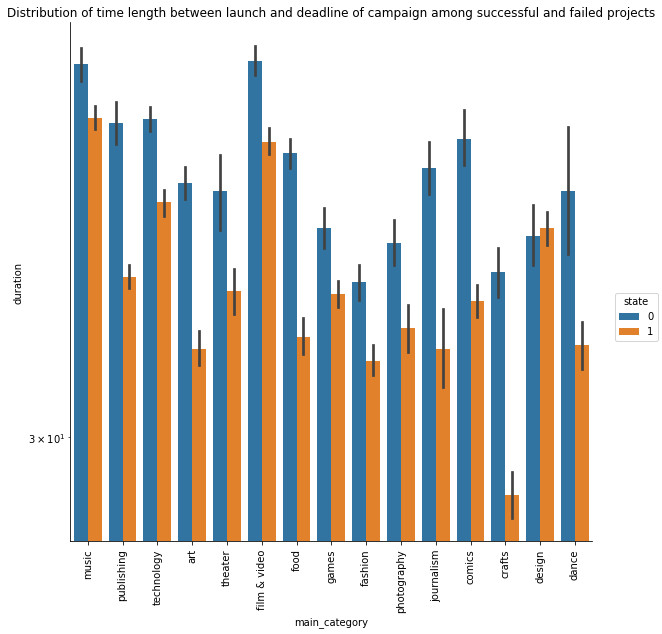

In [6]:
sns.factorplot(x='main_category', y='duration', hue='state', kind='bar', data=df, size=8)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Distribution of time length between launch and deadline of campaign among successful and failed projects')
plt.gca().set_yscale("log", nonposy='clip');

# Splitting the dataset into train/test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('state',axis=1,inplace=False),
                                                    df['state'],
                                                   test_size=0.2, random_state = 24)

# For RNN classifier
X_train_nlp = X_train[['country','main_category','category_name','name','blurb']] # RNN
X_test_nlp = X_test[['country','main_category','category_name','name','blurb']]

# For decision-tree classifier
X_train_dt = pd.get_dummies(X_train[['main_category','category_name','country','duration','goal']])
X_test_dt = pd.get_dummies(X_test[['main_category','category_name','country','duration','goal']])

print('Dimension of X_train = ',X_train.shape)
print('Dimension of X_test = ',X_test.shape)


# Output for hyperparameter tuning in another notebook
for files, file_name in zip([X_train_nlp, X_test_nlp, X_train_dt, X_test_dt, y_train, y_test],
                           ['X_train_nlp', 'X_test_nlp', 'X_train_dt', 'X_test_dt', 'y_train', 'y_test']):
    files.to_pickle(file_name)


# Training separate models before ensembling

## Model 0: Logistic Regression (not included in the ensemble)
- Logistic Regression is fast with sparse features, so I do gridsearch here instead of in a separate script.
- It achieves an accuracy lower than the decision-tree models and neural network model.

=====Performance of LogisticRegression (train set)=====
Accuracy: 0.7576
Precision: 0.8050
Recall: 0.7825
F1: 0.7936
[[42444 16433]
 [18855 67852]]
ROC AUC = 0.849979444238


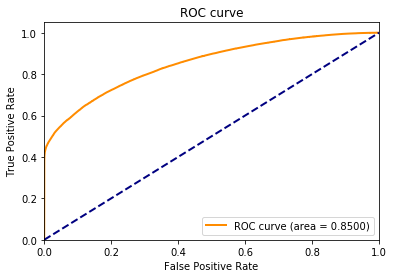

=====Performance of LogisticRegression (test set)=====
Accuracy: 0.7599
Precision: 0.8112
Recall: 0.7772
F1: 0.7938
[[10837  3916]
 [ 4822 16821]]
ROC AUC = 0.851744163113


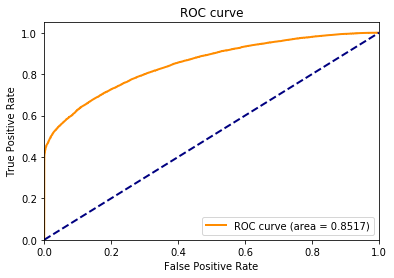

In [72]:
X_train_lr = pd.get_dummies(X_train[['main_category','category_name','country','duration','goal']])
X_test_lr = pd.get_dummies(X_test[['main_category','category_name','country','duration','goal']])
scaler = MinMaxScaler()
X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

grid_values = {'C': [10**i for i in range(-5,5)], 'penalty':['l1','l2']}
lr = LogisticRegression()
grid_clf_acc = GridSearchCV(lr, param_grid = grid_values, scoring='accuracy')

y_proba_train = grid_clf_acc.fit(X_train_lr, y_train).decision_function(X_train_lr)
y_pred_train = grid_clf_acc.fit(X_train_lr, y_train).predict(X_train_lr)
diagnostic_print(y_train,y_pred_train,y_proba_train,'LogisticRegression (train set)')

y_proba_test = grid_clf_acc.fit(X_test_lr, y_test).decision_function(X_test_lr)
y_pred_test = grid_clf_acc.fit(X_test_lr, y_test).predict(X_test_lr)
diagnostic_print(y_test,y_pred_test,y_proba_test,'LogisticRegression (test set)')

## Model 1: Random Forest

=====Performance of RandomForest=====
Accuracy: 0.7745
Precision: 0.8157
Recall: 0.8020
F1: 0.8088
[[10832  3921]
 [ 4285 17358]]
ROC AUC = 0.863431755019


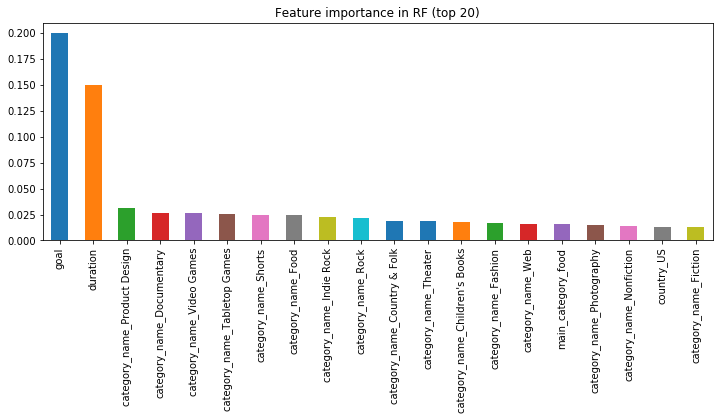

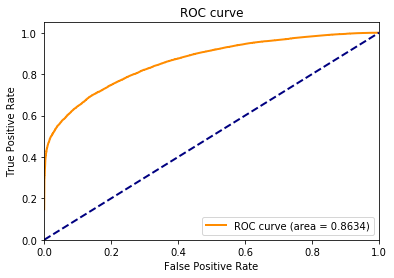

In [38]:
rf = RandomForestClassifier(n_estimators=15, max_features=10, max_depth=None, 
                            min_samples_leaf=3, min_samples_split=2,
                            bootstrap=False, criterion='entropy').fit(X_train_dt, y_train)
y_pred_rf = rf.predict(X_test_dt)
y_proba_rf = rf.fit(X_train_dt, y_train).predict_proba(X_test_dt)[:,1]

# Plot feature importance per category
plt.figure(figsize=(12,4))
pd.Series(rf.feature_importances_, index=X_train_dt.columns.tolist()).sort_values(ascending=False)[:20].plot.bar();
plt.title('Feature importance in RF (top 20)');

# Evaluate individual performance of each model
diagnostic_print(y_test,y_pred_rf,y_proba_rf,'RandomForest')


## Model 2: XGBoost

=====Performance of XGBoost=====
Accuracy: 0.7683
Precision: 0.8043
Recall: 0.8067
F1: 0.8055
[[10504  4249]
 [ 4183 17460]]
ROC AUC = 0.861666994765


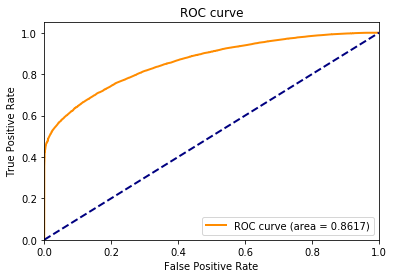

In [39]:
xgb = XGBClassifier(max_depth=10, min_child_weight=6)
xgb.fit(X_train_dt, y_train)

y_pred_xgb_train = xgb.predict(X_train_dt)
y_proba_xgb_train = xgb.predict_proba(X_train_dt)[:,1]

y_pred_xgb_test = xgb.predict(X_test_dt)
y_proba_xgb_test = xgb.predict_proba(X_test_dt)[:,1]

diagnostic_print(y_test,y_pred_xgb_test,y_proba_xgb_test,'XGBoost')

## Model 3: RNN (with LSTM units)

The country name, main category, sub-category together with the name and the blurb of the project are concatenated and yield a piece of text. It is then tokenized, encoded and fed into the model with LSTM units.

/Users/shaoyinghuang/anaconda/envs/trytensorflow/lib/python3.5/site-packages/keras/preprocessing/text.py:139: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Train on 131025 samples, validate on 14559 samples
Epoch 1/2
131025/131025 [==============================] - 177s - loss: 0.4804 - acc: 0.7482 - val_loss: 0.4324 - val_acc: 0.7806
Epoch 2/2
36352/36396 [============================>.] - ETA: 0s=====Performance of RNN=====
Accuracy: 0.7826
Precision: 0.8353
Recall: 0.7901
F1: 0.8121
[[11382  3371]
 [ 4543 17100]]
ROC AUC = 0.870959243838


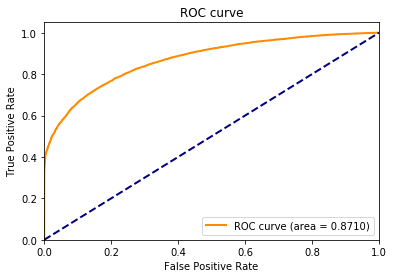

In [40]:
list_sentences_train = X_train_nlp['country'] + ' ' + X_train_nlp['main_category'] \
+ ' ' + X_train_nlp['category_name'] \
+ ' ' + X_train_nlp['name'] + ' ' + X_train_nlp['blurb']

list_sentences_test = X_test_nlp['country'] + ' ' + X_test_nlp['main_category'] \
+ ' ' + X_test_nlp['category_name'] \
+ ' ' + X_test_nlp['name'] + ' ' + X_test_nlp['blurb']

# Initial training parameters for RNN
max_features = 40000
embed_size = 128
batch_size = 128*2
epochs = 2
learning_rate = 0.001
lstm_units = 60
dropout_prop1, dropout_prop2, dropout_prop3 = 0.1, 0.1, 0.1
relu1_units, relu2_units = 16,16

# Tokenize the text
tokenizer = Tokenizer(nb_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
list_tokenized_train[:1]

len_list = [len(x) for x in list_tokenized_train]
maxlen = pd.Series(len_list).max()

X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(lstm_units, return_sequences=True,name='lstm_layer')(x)
try: # To fix difference in the version of Keras
    x = GlobalMaxPool1D()(x)
except:
    x = GlobalMaxPooling1D()(x)
x = Dropout(dropout_prop1)(x)
x = Dense(relu1_units, activation="relu")(x)
x = Dropout(dropout_prop2)(x)
x = Dense(1, activation="sigmoid")(x)
try: # To fix difference in the version of Keras
    rnn_model = Model(inputs=inp, outputs=x)
except:
    rnn_model = Model(input=inp, output=x)    

adam = Adam(lr=learning_rate)
rnn_model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

try: # To fix difference in the version of Keras
    rnn_model.fit(X_t,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
except:
    rnn_model.fit(X_t,y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.1)

y_proba_rnn = rnn_model.predict(X_te, batch_size=batch_size, verbose=1)
y_pred_rnn = [int(x>0.5) for x in y_proba_rnn.ravel().tolist()]

diagnostic_print(y_test,y_pred_rnn,y_proba_rnn,'RNN')

# Combining the models using soft-voting and hard-voting
- The ensemble by soft-voting gives the best performance among all the models.

=====Performance of Soft Voting=====
Accuracy: 0.8023
Precision: 0.8462
Recall: 0.8157
F1: 0.8307
[[11545  3208]
 [ 3989 17654]]
ROC AUC = 0.891681149609


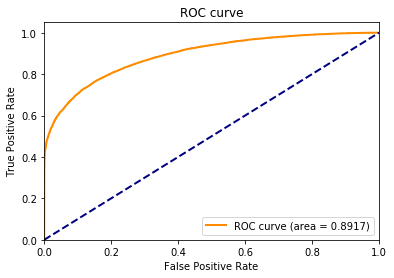

=====Performance of Hard Voting/MaxVote=====
Accuracy: 0.7894
Precision: 0.8286
Recall: 0.8144
F1: 0.8214
[[11107  3646]
 [ 4018 17625]]
ROC AUC = 0.783607442348


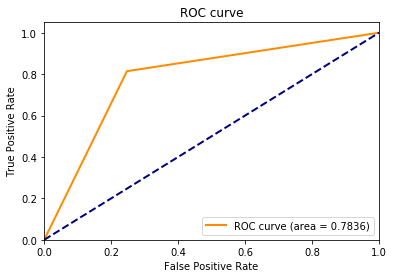

In [41]:
# Model ensemble: 

y_pred_hard = (y_pred_rf + y_pred_xgb_test + y_pred_rnn).tolist()
y_pred_hard = [1 if x>1 else 0 for x in y_pred_hard]
y_proba_soft = (y_proba_rf + y_proba_xgb_test + y_proba_rnn.ravel())/3.
y_pred_soft = [1 if x>0.5 else 0 for x in y_proba_soft]

diagnostic_print(y_test,y_pred_soft,y_proba_soft,'Soft Voting')

diagnostic_print(y_test,y_pred_hard,y_pred_hard,'Hard Voting/MaxVote')